In [1]:
import os
import io
from getpass import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageOps

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
import pyspark.sql.functions as F
from pyspark.ml.linalg import DenseVector, VectorUDT

import boto3

In [2]:
# Clés AMI pour accès S3
access_key = getpass(prompt="Clé d'accès pour S3") # Clé accès
secret_key = getpass(prompt='Clé secrète pour S3') # Clé secrète

Clé secrète pour S3 ········································


In [3]:
# Définition des variables d'environnement système pour accès S3
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key

In [4]:
# Accès S3 par boto3 et test
s3 = boto3.resource(
    service_name='s3',
    region_name='eu-west-1',
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_key
)

for bucket in s3.buckets.all():
    print(bucket.name)

oc-bucket-img


In [5]:
spark = (SparkSession
         .builder # Création d'une SparkSession
         .master('local[4]') # Allocation de tous les threads locaux disponibles
         .config('spark.executor.memory', '1500m') # Allocation de mémoire aux executors
         .appName('OC-P8') # Nom donné
         .getOrCreate())

In [6]:
data_url = "s3a://oc-bucket-img/Training-aws/*" # URL du dossier dans S3

In [7]:
df = spark.read.format("binaryfile").load(data_url) # Lecture des documents (images) contenues dans le dossier

In [8]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [9]:
df.select("path", "content").show(5)

+--------------------+--------------------+
|                path|             content|
+--------------------+--------------------+
|s3a://oc-bucket-i...|[FF D8 FF E0 00 1...|
|s3a://oc-bucket-i...|[FF D8 FF E0 00 1...|
|s3a://oc-bucket-i...|[FF D8 FF E0 00 1...|
|s3a://oc-bucket-i...|[FF D8 FF E0 00 1...|
|s3a://oc-bucket-i...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+
only showing top 5 rows



In [10]:
# Préprocessing des chemins d'accès => nom du fruit
def cat_extract(path):
    """
    Fonction donnant le nom du dossier indiqué par le chemin path.
    """
    path = os.path.dirname(path)
    return os.path.basename(path)

In [11]:
# Création d'une user-defined function pour extraire le nom du dossier = nom du fruit, pour classifier
path2name = F.udf(lambda x: cat_extract(x))

In [12]:
# Application à nos données par spark
df_prep = df.withColumn("name", path2name("path")).select('name', 'content')
df_prep.printSchema()

root
 |-- name: string (nullable = true)
 |-- content: binary (nullable = true)



In [33]:
# Préprocessing des images
def preprocess(content, imgsize=[100, 100]):
    """
    Préprocessing des images : changement de taille, et correction de l'histogramme.
    Par défaut, taille d'image en 100px x 100px.
    """
    img = Image.open(io.BytesIO(content))
    if imgsize != None:
        img = img.resize(imgsize)
    img = ImageOps.autocontrast(img)
    img = ImageOps.equalize(img)
    arr = np.asarray(img)
    return arr

In [14]:
# Création d'une user-defined function pour le préprocessing des images ligne à ligne
img_size = [30, 30]
img2vec = F.udf(lambda x: DenseVector(preprocess(x, img_size).flatten()/255), VectorUDT())

In [15]:
# Application à nos données par spark
df_prep = df_prep.withColumn("content", img2vec("content"))
df_prep.show(5)

+--------------+--------------------+
|          name|             content|
+--------------+--------------------+
|     Raspberry|[1.0,1.0,1.0,1.0,...|
|     Raspberry|[1.0,1.0,1.0,1.0,...|
|Pineapple Mini|[1.0,1.0,1.0,1.0,...|
|Pineapple Mini|[1.0,1.0,1.0,1.0,...|
|     Raspberry|[1.0,1.0,1.0,0.99...|
+--------------+--------------------+
only showing top 5 rows



In [16]:
nrow = df_prep.count()
ncol = 3*np.prod(img_size)

print(f"La base de données du contenu des images contient {nrow} lignes (images) et {ncol} colonnes (dimensions).")

La base de données du contenu des images contient 655 lignes (images) et 2700 colonnes (dimensions).


In [17]:
# Etape de réduction dimensionnelle par PCA
k = int(ncol/50) # Ne retenir qu'1/50 dimensions
pca = PCA(k=k, inputCol="content", outputCol="pca_feat")
pca_f = pca.fit(df_prep)

In [18]:
# Application de la réduction dimensionnelle à notre base
pca_df = pca_f.transform(df_prep)

In [19]:
pca_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- content: vector (nullable = true)
 |-- pca_feat: vector (nullable = true)



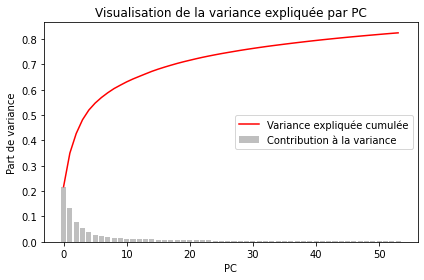

In [20]:
# Contribution des valeurs propres
exp_var_pca = pca_f.explainedVariance.toArray()

# Somme cumulée des valeurs propres
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Visualisation
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, color='grey', align='center', label='Contribution à la variance')
plt.plot(cum_sum_eigenvalues, c='red', label='Variance expliquée cumulée')
plt.ylabel("Part de variance")
plt.xlabel("PC")
plt.legend(loc='center right')
plt.title("Visualisation de la variance expliquée par PC")
plt.tight_layout()
plt.show()

In [21]:
print(f"Les PC retenues permettent d'expliquer {cum_sum_eigenvalues[-1]:.0%} de la variance totale de l'échantillon.")

Les PC retenues permettent d'expliquer 82% de la variance totale de l'échantillon.


In [22]:
# Enregistrement du modèle
pca_f.write().overwrite().save("model/pca")